In [1]:
!nvidia-smi

Tue Feb  8 13:19:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  N/A |
| 30%   35C    P8    25W / 260W |   4762MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from matplotlib.gridspec import GridSpec

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler
from statsmodels.tsa.seasonal import STL

# Make the graphs a bit prettier, and bigger
matplotlib.style.use('ggplot')

In [2]:
class cfg(object):
    seq_len = 64
    forecast_steps = 1
    differential = True
    remove_peak = False
    test_stl = False
    stl_period = seq_len
    num_filters = 32
    kernel_size = 8
    num_residual_blocks = np.int8(np.ceil(np.log2(seq_len)))
    model_name = 'MODS2_WaveNet'
    model_dir = os.path.join('..', 'models')
    model_file = os.path.join(model_dir, 'MODS2_WaveNet.h5')
    class train(object):
        shuffle = False
        batch_size = 1
        epochs = 100
        patience = 10
        class data(object):
            file = os.path.join('buffer-all-1M.tsv')
            split = 0.8
            X = [
                'conn_count_uid_in',
                'conn_count_uid_out',
                'dns_count_uid_out',
                'http_count_uid_in',
                'ssl_count_uid_in'
            ]
            Y = [
                'conn_count_uid_in',
                'conn_count_uid_out',
                'dns_count_uid_out',
                'http_count_uid_in',
                'ssl_count_uid_in'
            ]
    tsg = {
        'length': seq_len,
        'sampling_rate': 1,
        'stride': 1,
        'batch_size': train.batch_size
    }

print("cfg.seq_len:", cfg.seq_len)
print("cfg.forecast_steps:", cfg.forecast_steps)
print("cfg.differential:", cfg.differential)
print("cfg.remove_peak:", cfg.remove_peak)
print("cfg.test_stl:", cfg.test_stl)
print("cfg.stl_period:", cfg.stl_period)
print("cfg.num_filters:", cfg.num_filters)
print("cfg.kernel_size:", cfg.kernel_size)
print("cfg.num_residual_blocks:", cfg.num_residual_blocks)
print("cfg.model_name:", cfg.model_name)
print("cfg.model_dir:", cfg.model_dir)
print("cfg.model_file:", cfg.model_file)
print("cfg.train.shuffle:", cfg.train.shuffle)
print("cfg.train.batch_size:", cfg.train.batch_size)
print("cfg.train.epochs:", cfg.train.epochs)
print("cfg.train.patience:", cfg.train.patience)
print("cfg.train.data.file:", cfg.train.data.file)
print("cfg.train.data.split:", cfg.train.data.split)
print("cfg.train.data.X:", cfg.train.data.X)
print("cfg.train.data.Y:", cfg.train.data.Y)
print("cfg.tsg:", cfg.tsg)

cfg.seq_len: 64
cfg.forecast_steps: 1
cfg.differential: True
cfg.remove_peak: False
cfg.test_stl: False
cfg.stl_period: 64
cfg.num_filters: 32
cfg.kernel_size: 8
cfg.num_residual_blocks: 6
cfg.model_name: MODS2_WaveNet
cfg.model_dir: ../models
cfg.model_file: ../models/MODS2_WaveNet.h5
cfg.train.shuffle: False
cfg.train.batch_size: 1
cfg.train.epochs: 100
cfg.train.patience: 10
cfg.train.data.file: buffer-all-1M.tsv
cfg.train.data.split: 0.8
cfg.train.data.X: ['conn_count_uid_in', 'conn_count_uid_out', 'dns_count_uid_out', 'http_count_uid_in', 'ssl_count_uid_in']
cfg.train.data.Y: ['conn_count_uid_in', 'conn_count_uid_out', 'dns_count_uid_out', 'http_count_uid_in', 'ssl_count_uid_in']
cfg.tsg: {'length': 64, 'sampling_rate': 1, 'stride': 1, 'batch_size': 1}


In [3]:
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.0
session = InteractiveSession(config=config)

2022-02-08 13:22:39.278282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 13:22:39.872771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11016 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation, Add, Conv1D, Concatenate, Dense, Dropout, Flatten, Input, Multiply, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
def norm_(x, xmin=-1, xmax=1):
    return (xmax-xmin) * (x - np.min(x)) / (np.max(x) - np.min(x)) + xmin

def norm(X, xmin=-1, xmax=1):
    return np.apply_along_axis(norm_, 0, X, xmin=xmin, xmax=xmax)

def norm_inv_(x, min_, max_, xmin=-1, xmax=1):
    return ((max_ - min_) * x - (max_ - min_) * xmin) / (xmax - xmin) + min_

def norm_inv(X, min_, max_, xmin=-1, xmax=1):
    return np.apply_along_axis(norm_inv_, 0, X, min_, max_, xmin=xmin, xmax=xmax)

def mu_law_(x, mu=255):
    return np.sign(x) * (np.log(1 + mu * np.absolute(x)) / np.log(1 + mu))

def mu_law(X, mu=255):
    return np.apply_along_axis(mu_law_, 0, X, mu=mu)

def mu_law_inv_(x, mu=255):
    return np.sign(x) * (1 / mu) * (((1 + mu) ** np.abs(x)) - 1)

def mu_law_inv(X, mu=255):
    return np.apply_along_axis(mu_law_inv_, 0, X, mu=mu)

def float64_to_int8_(x, xmin=-1, xmax=1):
    x = ((x - xmin) / (xmax - xmin)) * 255
    x = x.astype(np.uint8)
    return x

def float64_to_int8(X, xmin=-1, xmax=1):
    return np.apply_along_axis(float64_to_int8_, 0, X, xmin=xmin, xmax=xmax)

def int8_to_float64_(x, xmin=-1, xmax=1):
    x = (xmax - xmin) * (x / 255) + xmin
    x = x.astype(np.float64)
    return x

def int8_to_float64(X, xmin=-1, xmax=1):
    return np.apply_along_axis(int8_to_float64_, 0, X, xmin=xmin, xmax=xmax)

def one_hot(X, dim=256):
    return np.eye(dim, dtype="uint8")[X]

def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def differentiate(df:pd.DataFrame, k) -> pd.DataFrame:
    return df[k:]-df[:-k].values

def inverse_differentiate(df:pd.DataFrame, seen:pd.DataFrame, k) -> pd.DataFrame:
    return seen.values+df

def transform(df:pd.DataFrame) -> pd.DataFrame:
    if cfg.differential:
        return differentiate(df, cfg.forecast_steps)
    else:
        return df

def inverse_transform(df:pd.DataFrame, df_orig:pd.DataFrame) -> pd.DataFrame:
    if cfg.differential:
        return df + df_orig[cfg.seq_len+cfg.forecast_steps-1:-cfg.forecast_steps].values
    else:
        return df

def create_train_generator(data, seq_len=cfg.seq_len, batch_size=cfg.train.batch_size):
    X = norm(data)
    Y = float64_to_int8(mu_law(X))
    return TimeseriesGenerator(
        X,
        one_hot(Y),
        length=seq_len,
        sampling_rate=1,
        stride=1,
        batch_size=batch_size
    )

In [7]:
# read data from file
data_df = pd.read_csv(cfg.train.data.file, sep='\t')
data_df = data_df.set_index('ts')
data_df.index = pd.to_datetime(data_df.index)

In [8]:
# select data
cols = list(set(cfg.train.data.X + cfg.train.data.Y))
cols.sort()
data_df = data_df[cols]

In [9]:
# interpolate missing data
data_df = data_df.interpolate(method="time")

In [10]:
# split data
data_df_train, data_df_test = split_df(data_df, split=cfg.train.data.split)

In [11]:
# select cols for X and Y
data_df_train_X = data_df_train[cfg.train.data.X]
data_df_train_Y = data_df_train[cfg.train.data.Y]
data_df_test_X = data_df_test[cfg.train.data.X]
data_df_test_Y = data_df_test[cfg.train.data.Y]

In [12]:
# transform
data_df_train_X_t = transform(data_df_train_X)
data_df_train_Y_t = transform(data_df_train_Y)
data_df_test_X_t = transform(data_df_test_X)
data_df_test_Y_t = transform(data_df_test_Y)

In [13]:
# type casting
data_np_train_X = data_df_train_X_t.values.astype('float32')
data_np_train_Y = data_df_train_Y_t.values.astype('float32')

data_np_test_X = data_df_test_X_t.values.astype('float32')
data_np_test_Y = data_df_test_Y_t.values.astype('float32')

In [14]:
# normalize+transform XY train data
data_np_train_X_n = norm(data_np_train_X)
data_np_train_Y_n = float64_to_int8(mu_law(norm(data_np_train_Y)))

# normalize+transform XY test data
data_np_test_X_n = norm(data_np_test_X)
data_np_test_Y_n = float64_to_int8(mu_law(norm(data_np_test_Y)))

In [15]:
# @giang
class GiangTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1, remove_peak=cfg.remove_peak, test_stl=cfg.test_stl, stl_period=cfg.stl_period):
        self.epsilon = epsilon
        self.remove_peak = remove_peak
        self.test_stl = test_stl
        self.stl_period = stl_period
        self.isfitted = False
    def fit(self, X):
        if self.remove_peak:
            q_min, q_max = np.percentile(X, [25, 75], axis=0)
            iqr = q_max - q_min
            self.iqr_min = q_min - 1.5*iqr
            self.iqr_max = q_max + 1.5*iqr            
        self.isfitted = True
        return self
    def transform(self, X):
        X_ = X.copy()
        if self.test_stl:
            for col in range(X_.shape[1]):
                res = STL(X_[:,col], period=self.stl_period, robust=True).fit()
                X_[:,col] = res.trend + res.seasonal
        if not self.isfitted:
            self.fit(X_)
        if self.remove_peak:
            X_ = np.clip(X_, a_min=self.iqr_min, a_max=self.iqr_max)
        X_ = np.where(X_ < 0, self.epsilon, X_)
        return X_
    def inverse_transform(self, X):
        X_ = X.copy()
        return X_
        
# @giang
transform_pipeline_X = Pipeline([
    ('GiangTransformer', GiangTransformer()),
    ('MinMaxScaler', MinMaxScaler(feature_range=(0, 1)))
])

# @giang
transform_pipeline_Y = Pipeline([
    ('GiangTransformer', GiangTransformer()),
    ('MinMaxScaler', MinMaxScaler(feature_range=(0, 1)))
])

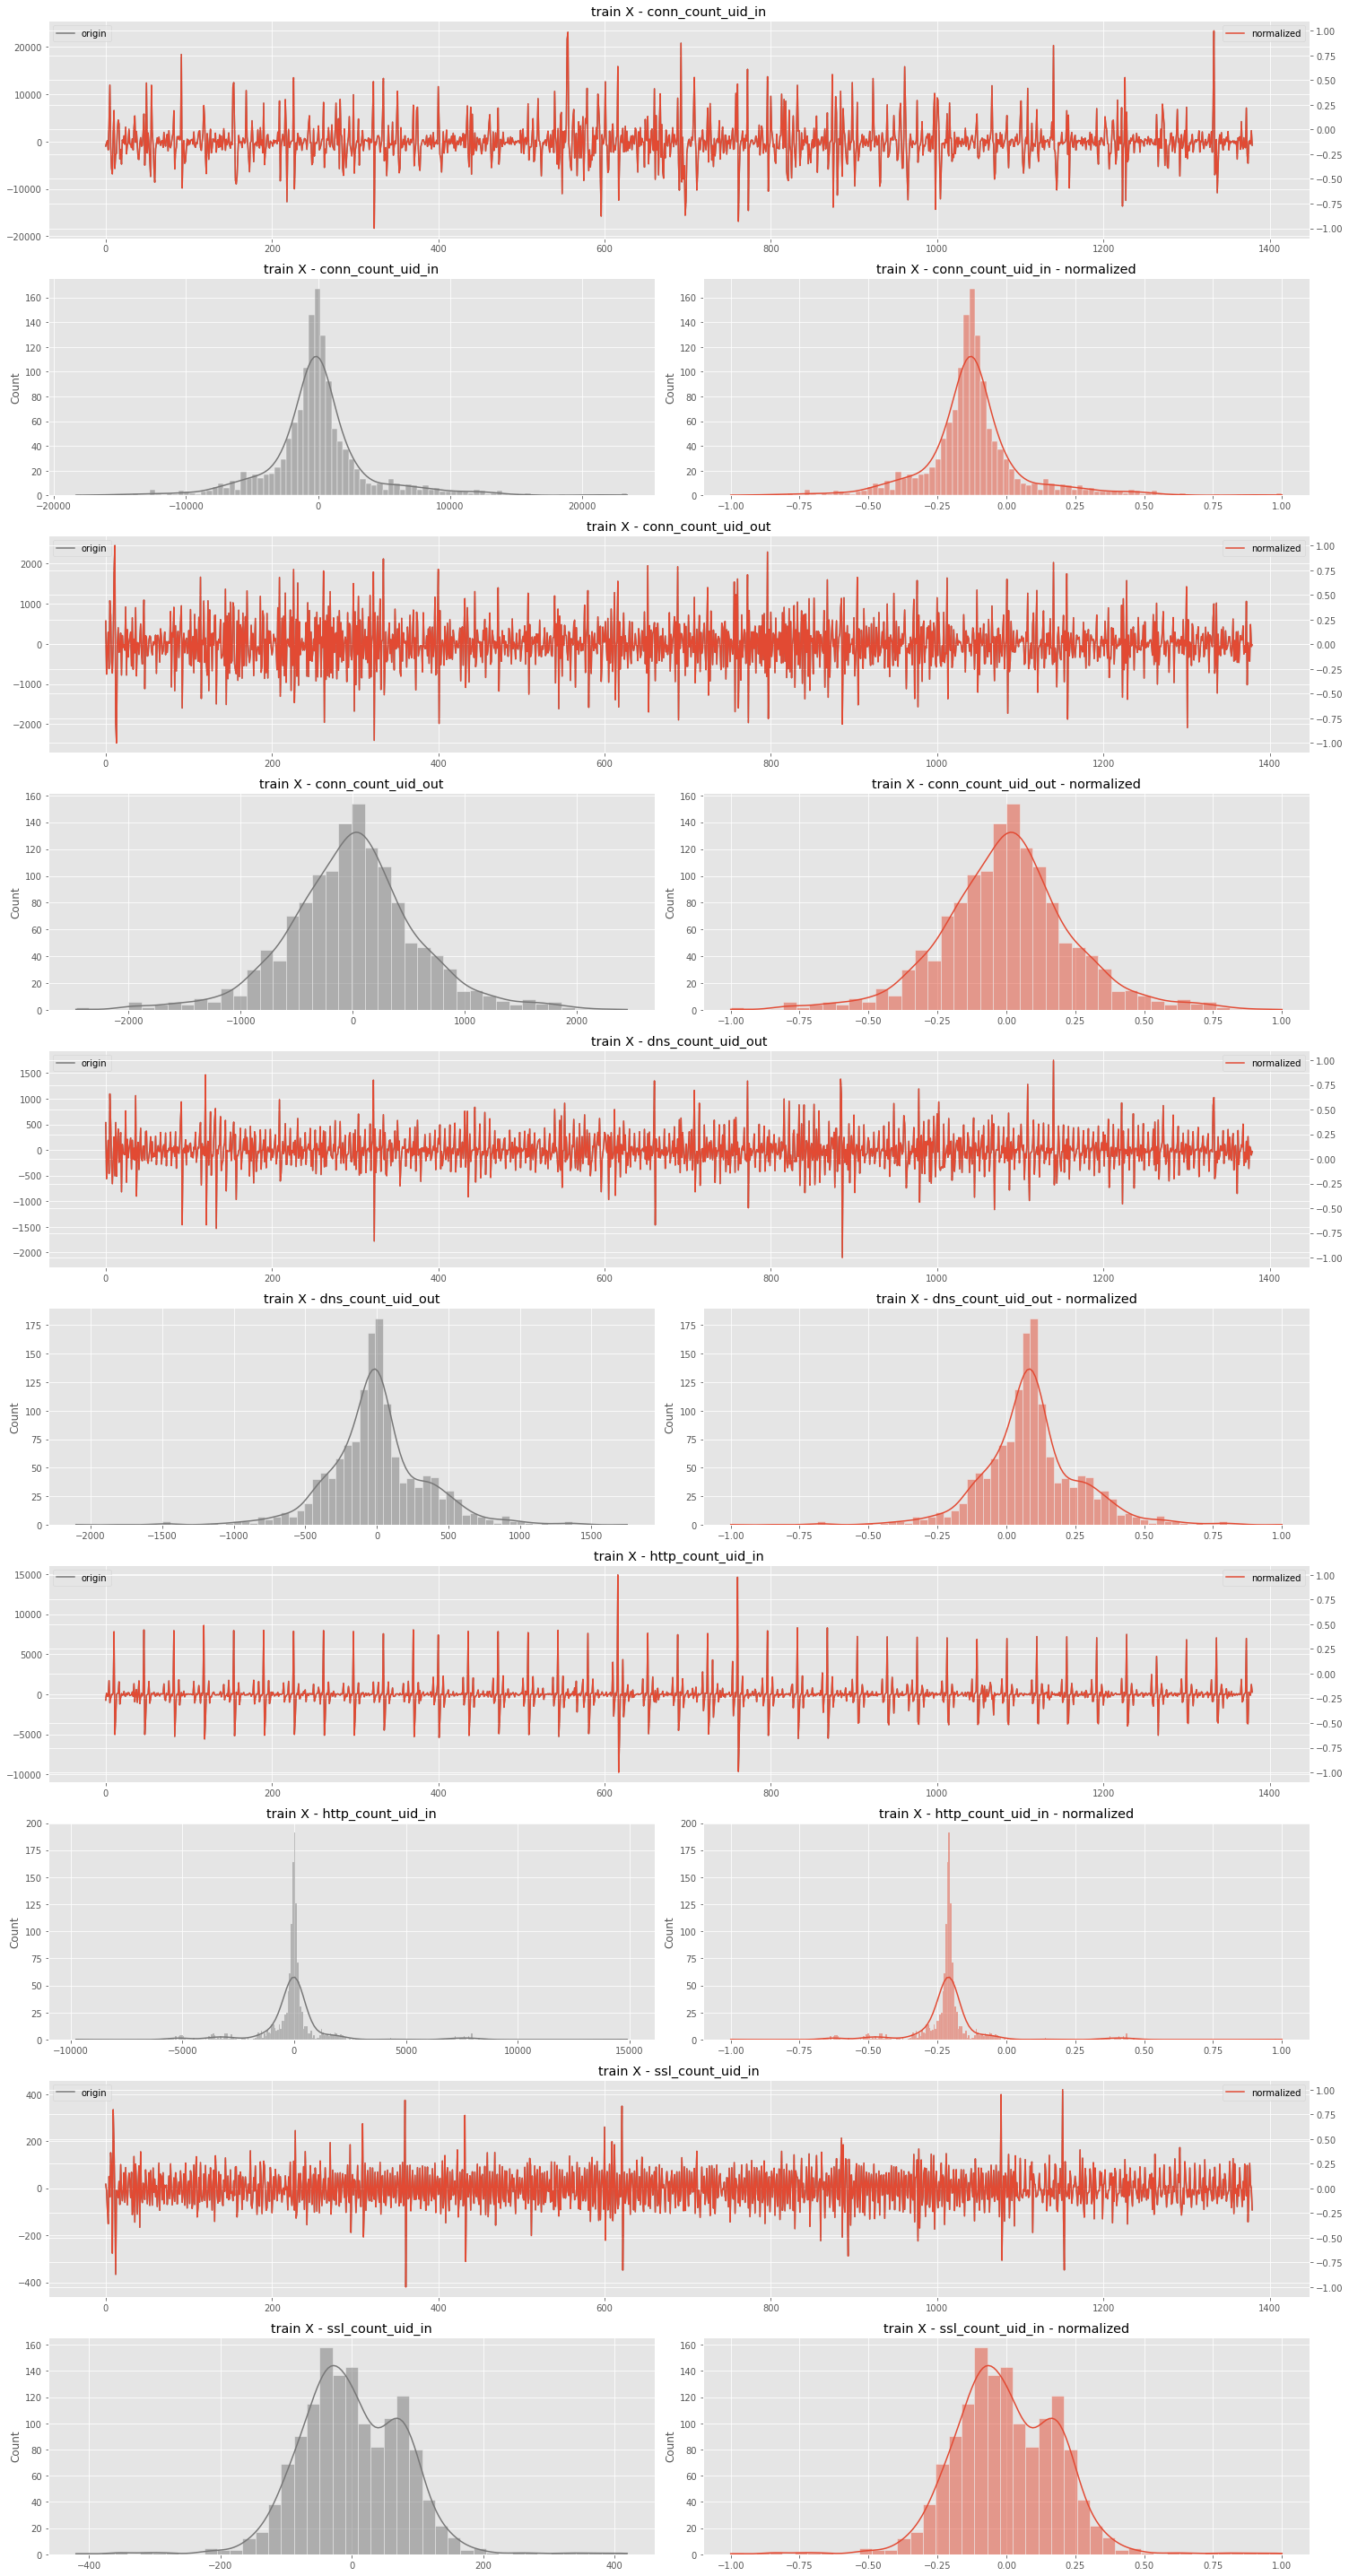

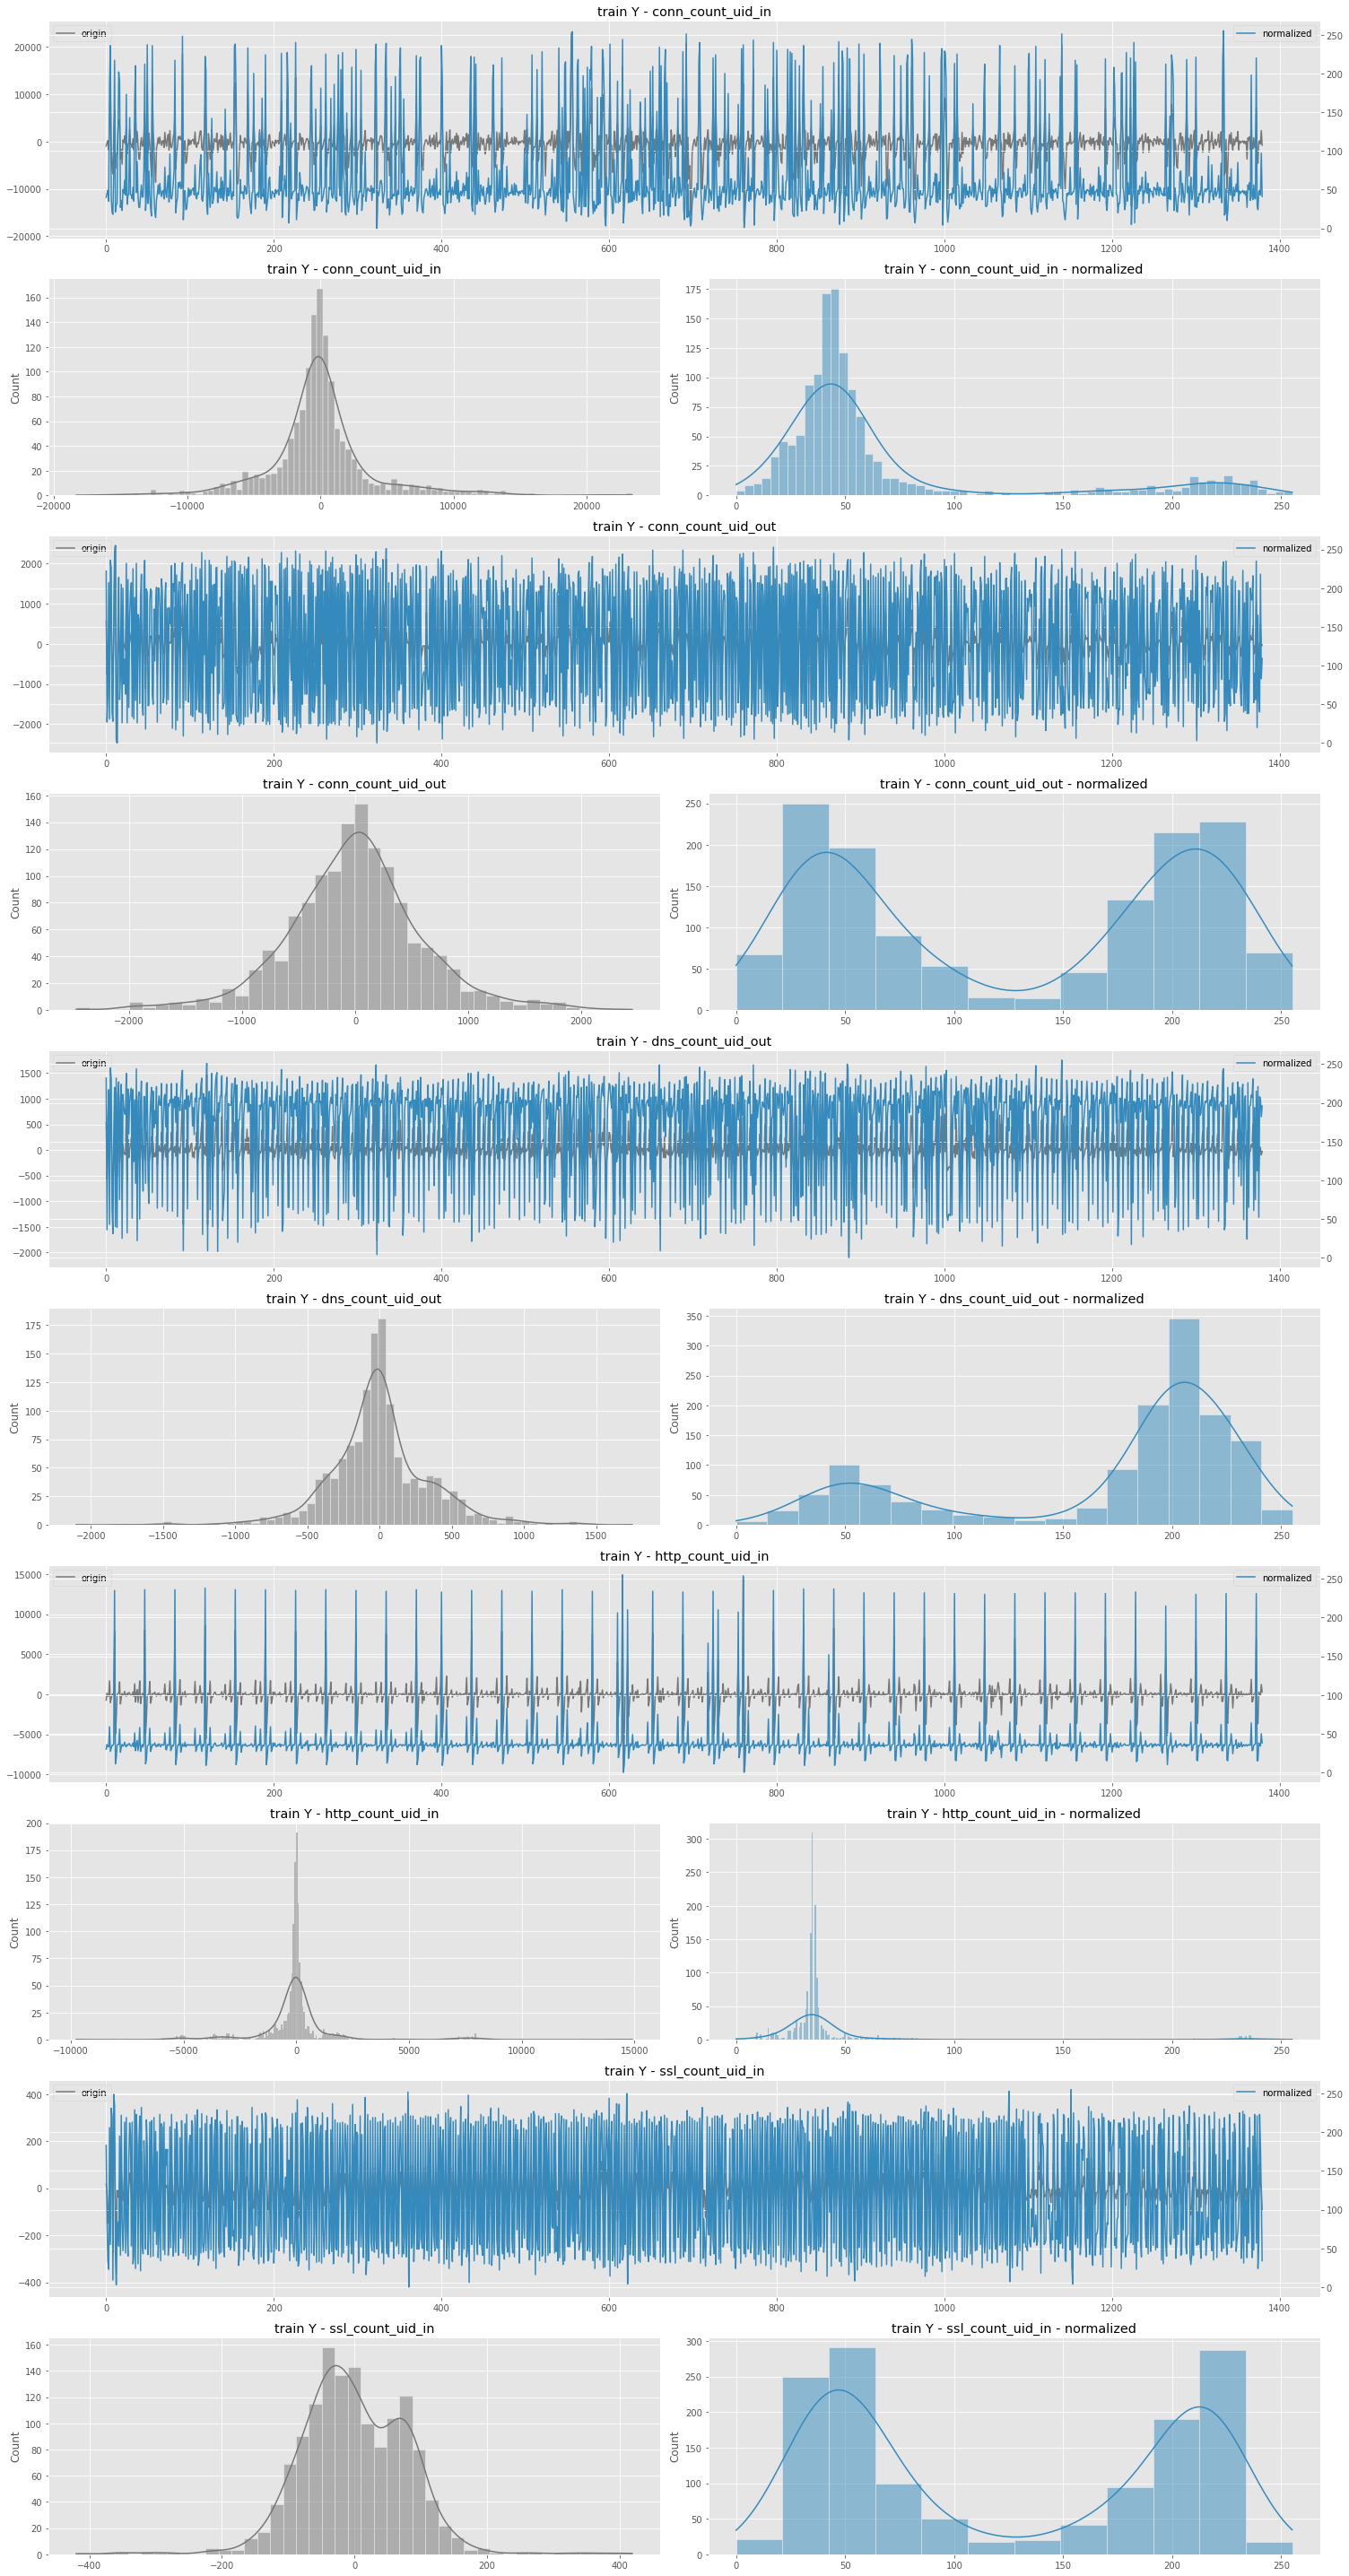

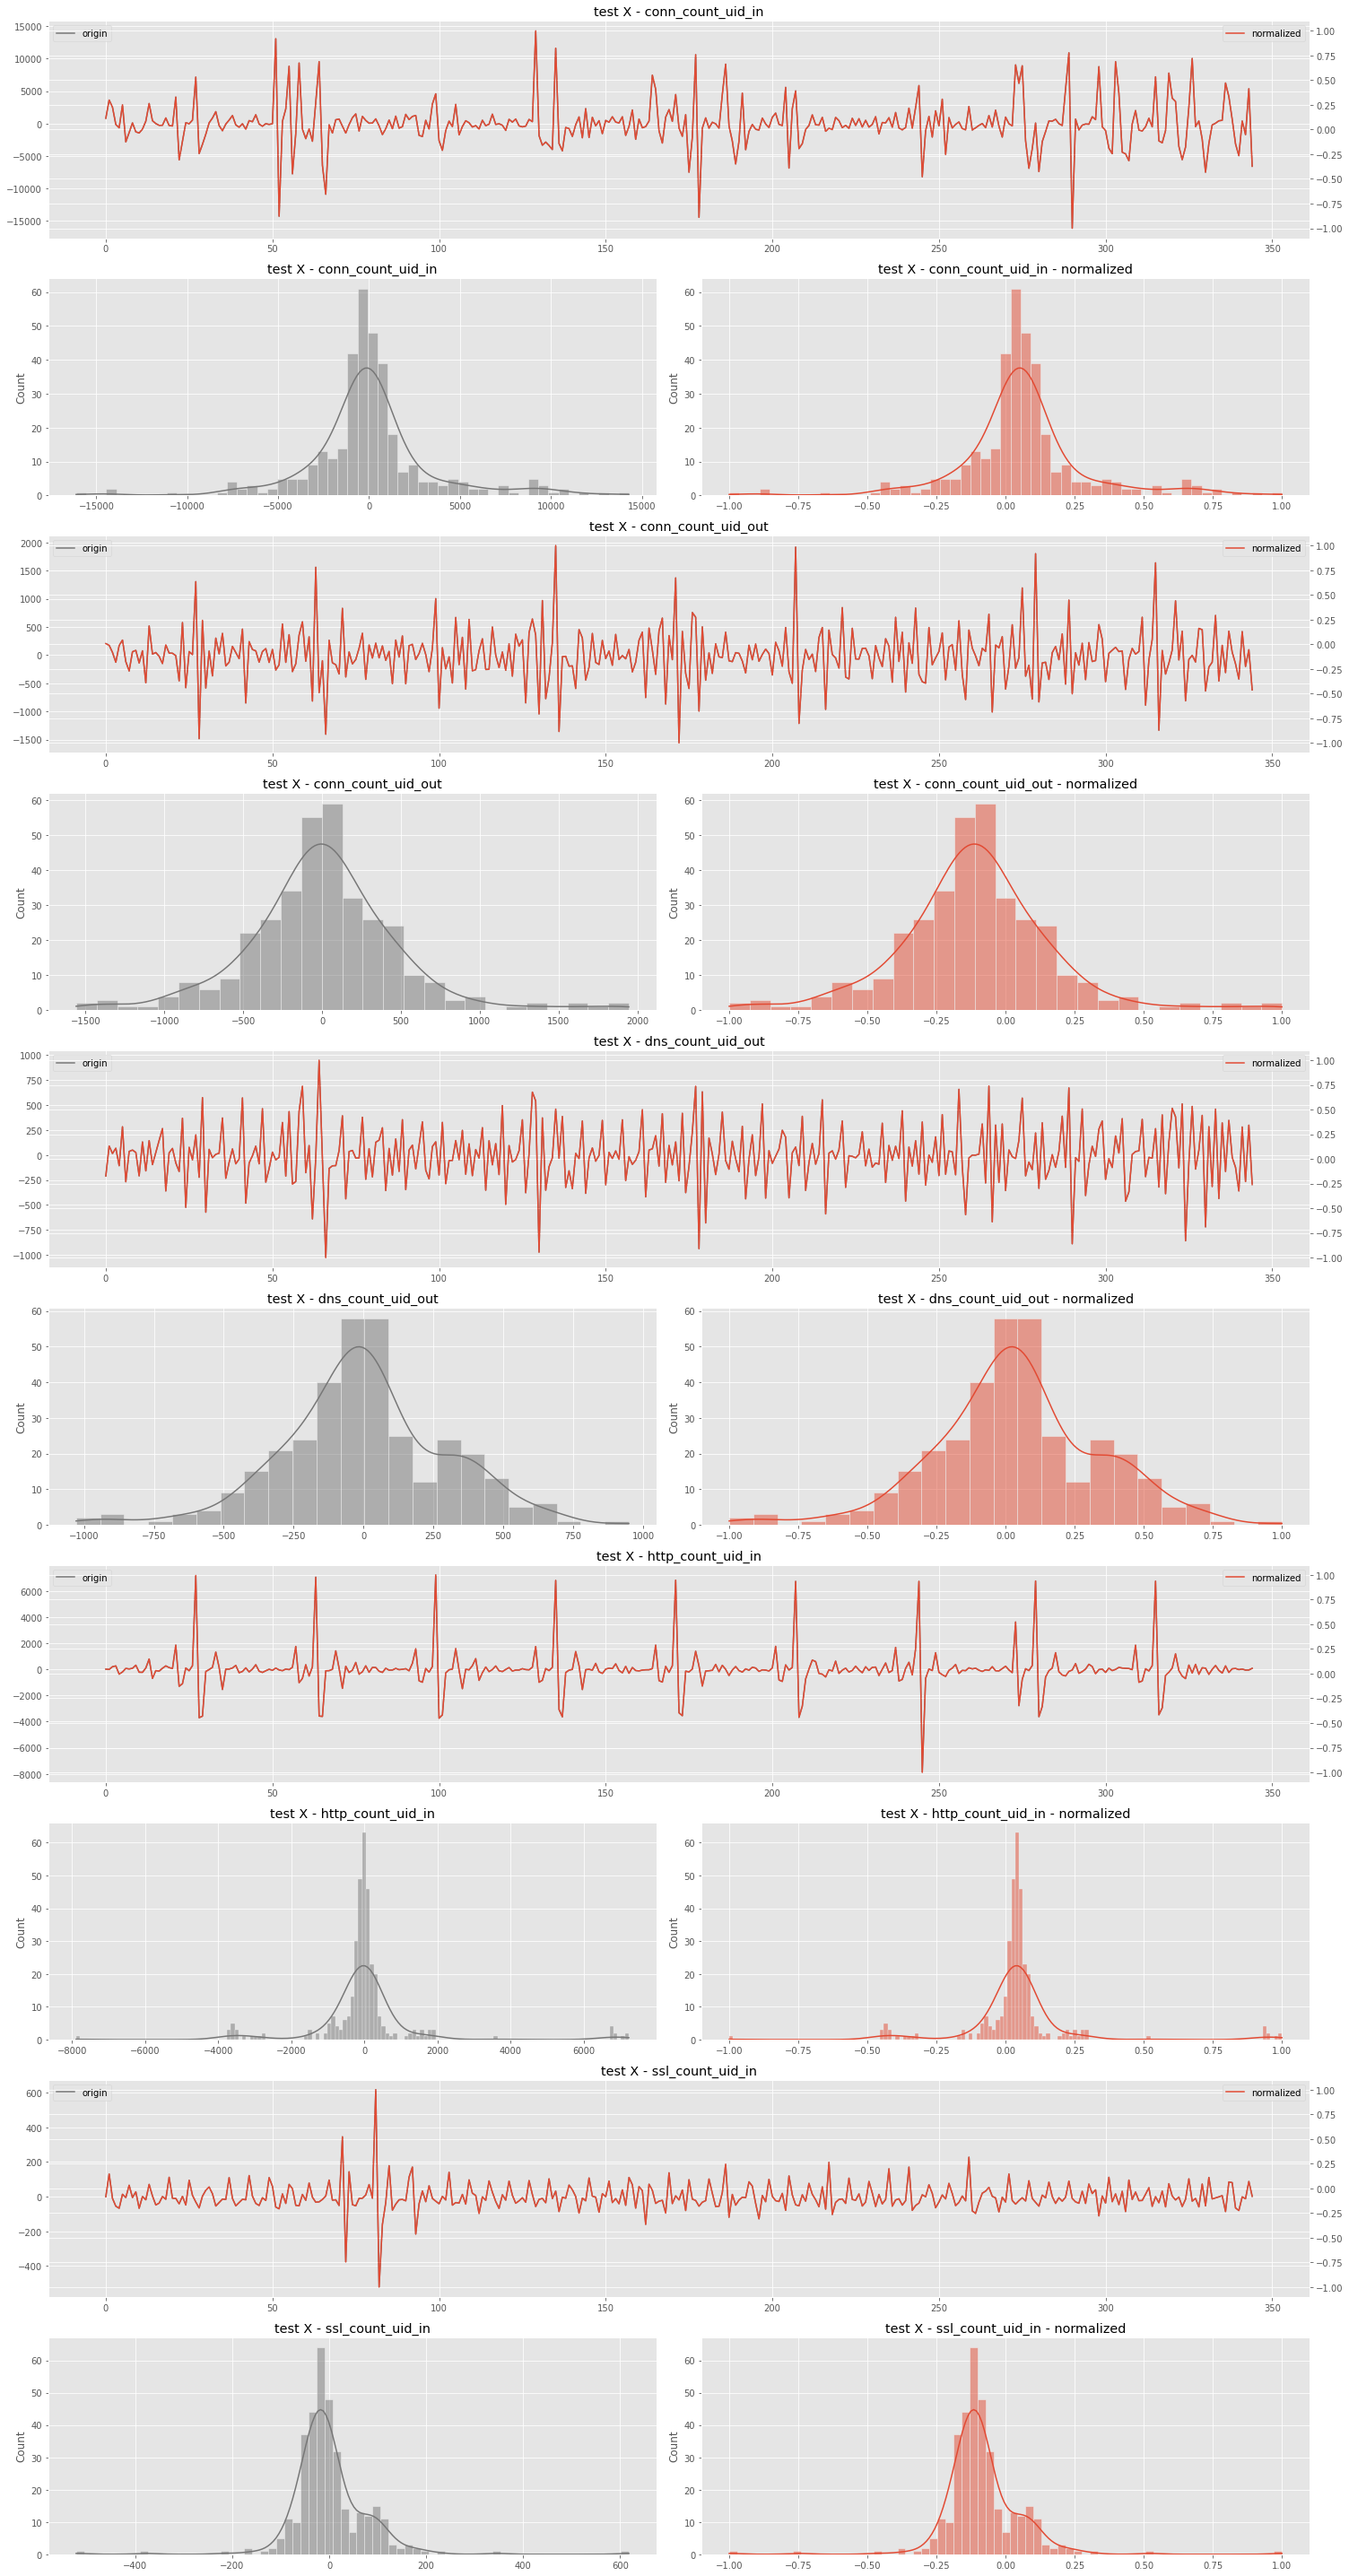

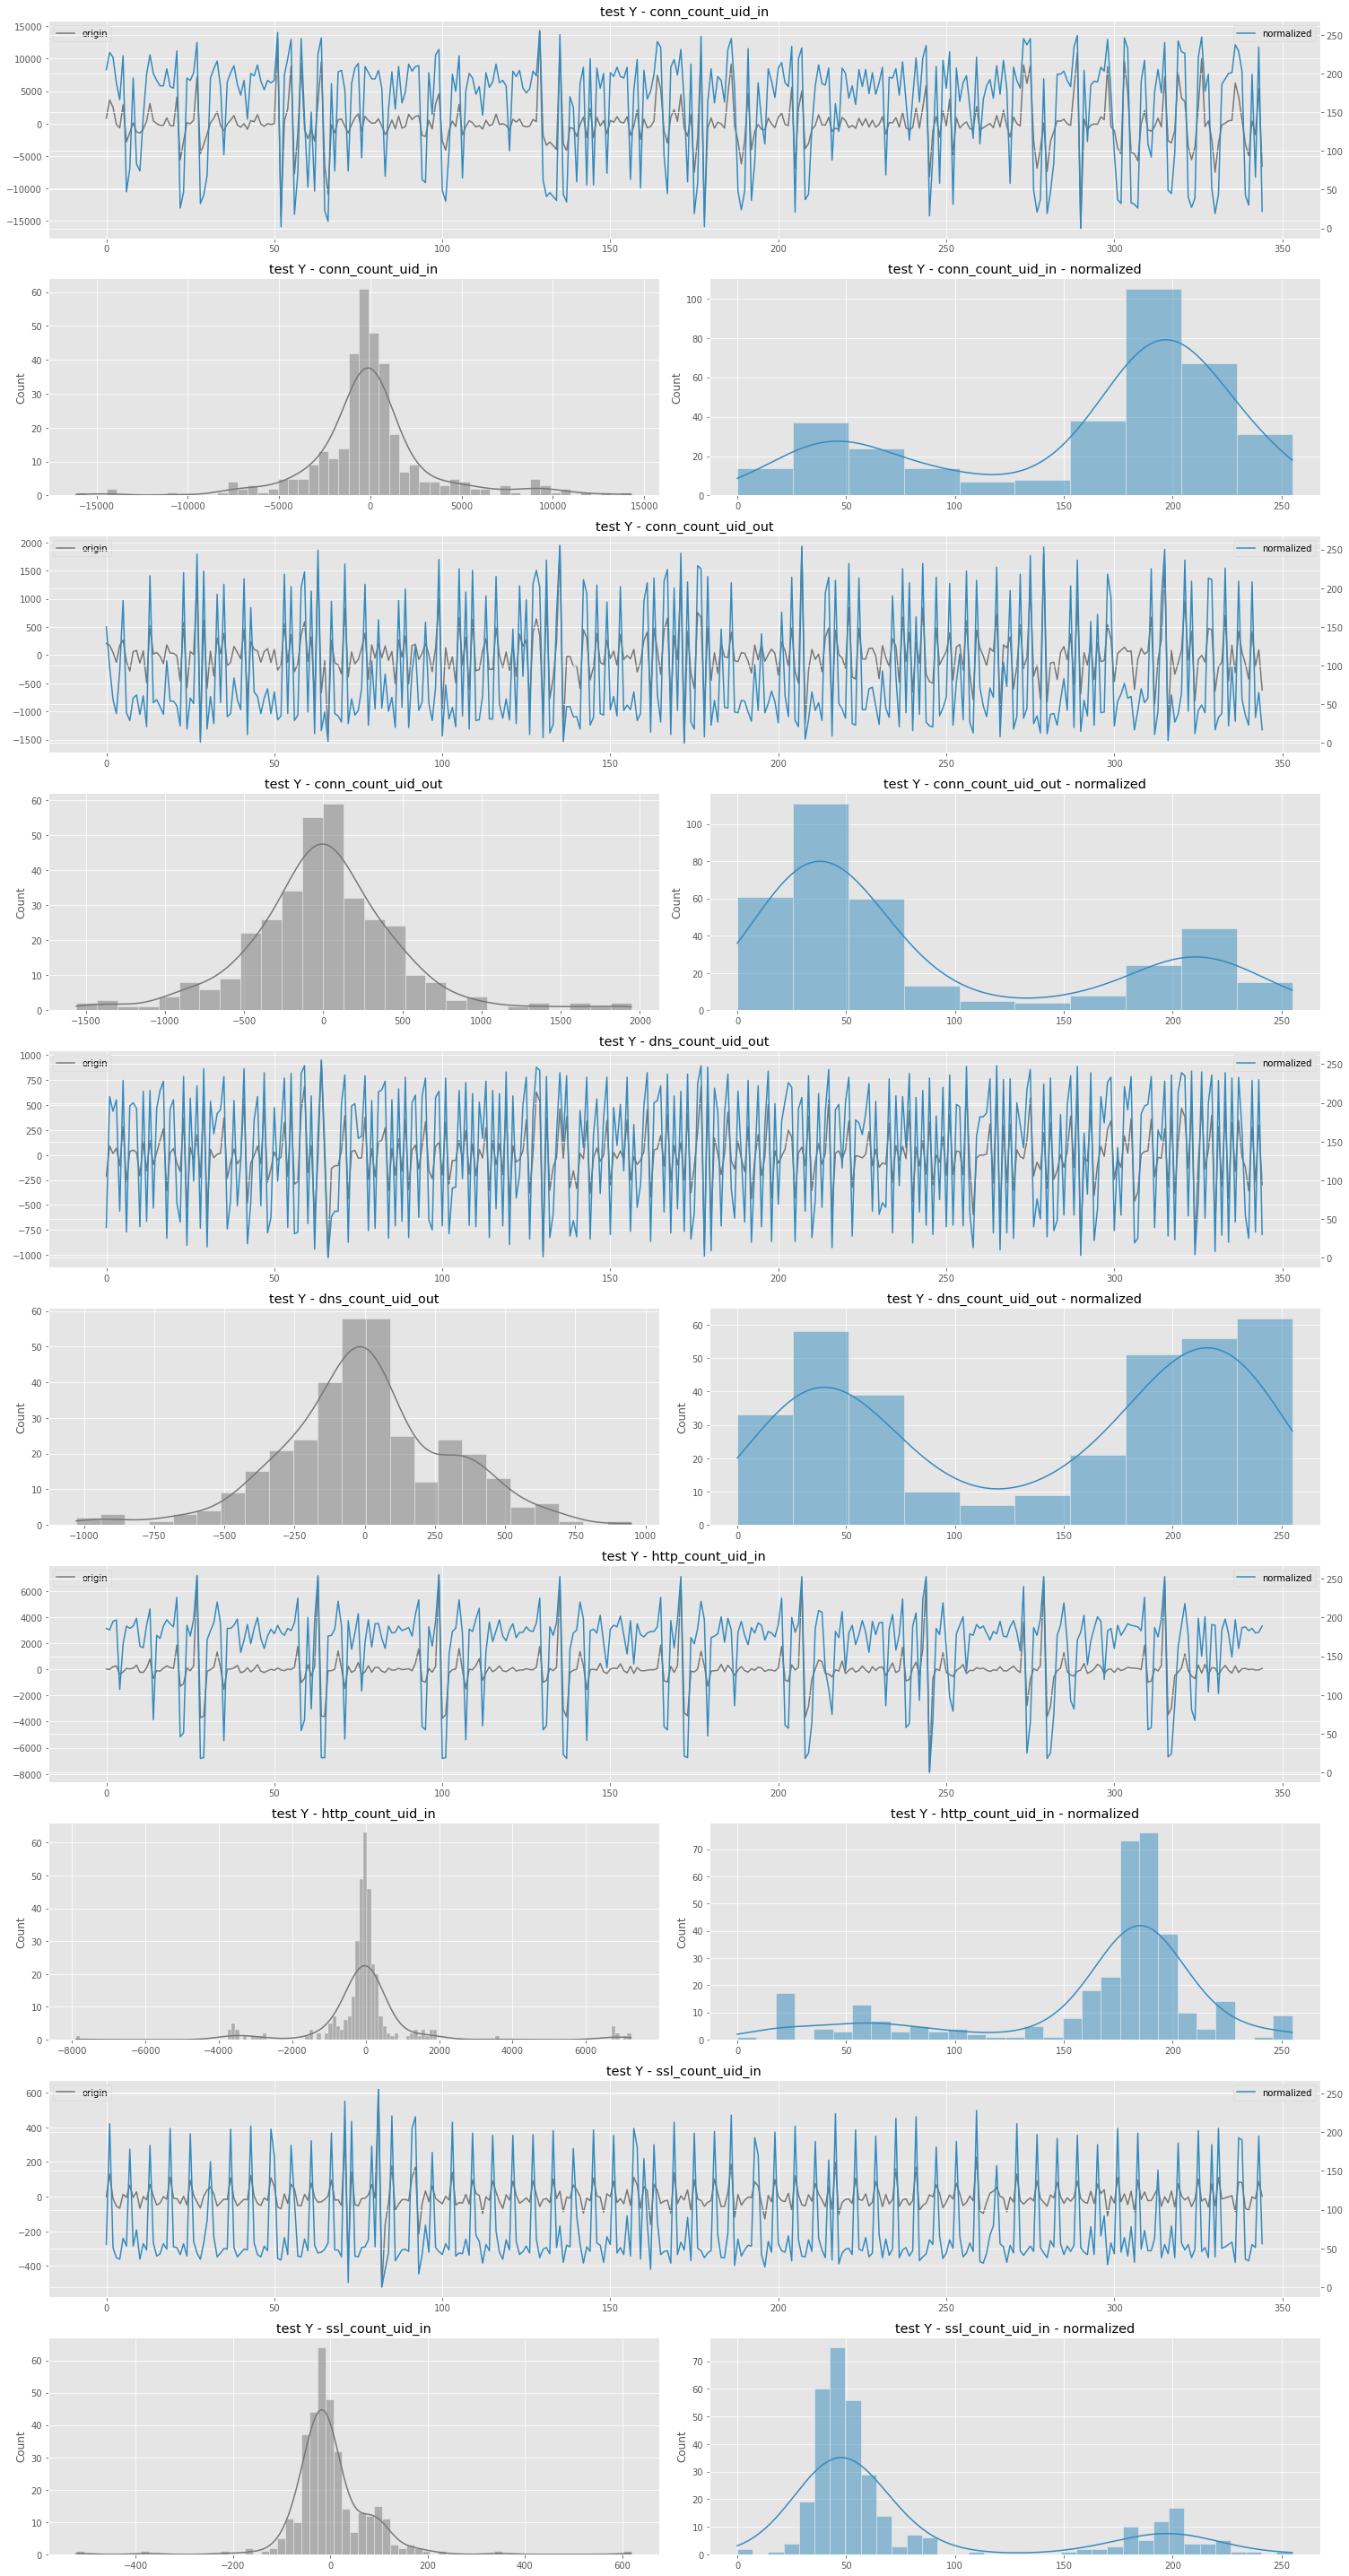

In [16]:
def plot_hist_orig_norm(prefix, orig, norm, cols, c1, c2):
    
    fig = plt.figure(figsize=(21,2*4*orig.shape[1]))
    gs = GridSpec(2*orig.shape[1], 2, figure=fig)
    
    for i in range(orig.shape[1]):
        
        ax = fig.add_subplot(gs[i*2,:])
        ax.plot(orig[:,i], label='origin', color=c1)
        twinx = ax.twinx()
        twinx.plot(norm[:,i], label='normalized', color=c2)
        ax.set_title('%s%s' % (prefix, cols[i]))
        ax.legend(loc='upper left')
        twinx.legend(loc='upper right')
        
        ax = fig.add_subplot(gs[i*2+1,0])
        sns.histplot(orig[:,i], kde=True, ax=ax, color=c1)
        ax.set_title('%s%s' % (prefix,cols[i]))

        ax = fig.add_subplot(gs[i*2+1,1])
        sns.histplot(norm[:,i], kde=True, ax=ax, color=c2)
        ax.set_title('%s%s - normalized' % (prefix,cols[i]))
    
    fig.tight_layout()
    plt.show()
    
plot_hist_orig_norm('train X - ', data_np_train_X, data_np_train_X_n, data_df_train_X.columns, 'C3', 'C0')
plot_hist_orig_norm('train Y - ', data_np_train_Y, data_np_train_Y_n, data_df_train_Y.columns, 'C3', 'C1')

plot_hist_orig_norm('test X - ', data_np_test_X, data_np_test_X_n, data_df_test_X.columns, 'C3', 'C0')
plot_hist_orig_norm('test Y - ', data_np_test_Y, data_np_test_Y_n, data_df_test_Y.columns, 'C3', 'C1')

### transformation check

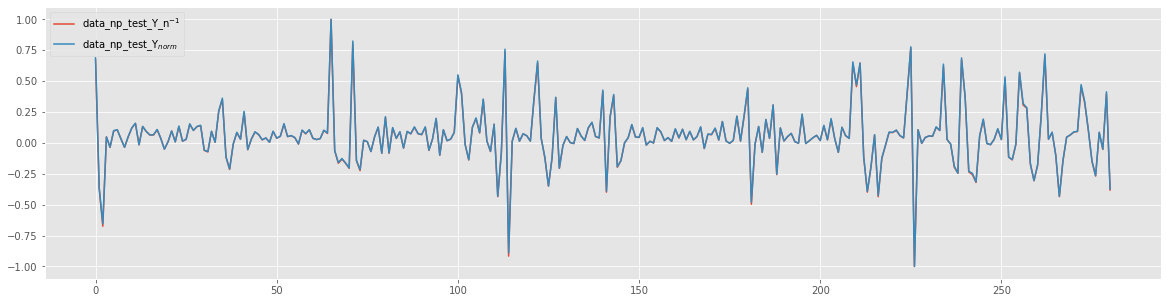

In [17]:
plt.plot(
    mu_law_inv(
        int8_to_float64(
            data_np_test_Y_n[cfg.seq_len:,0]
        )
    ),
    figure=plt.figure(figsize=(20,5)),
    label=r'data_np_test_Y_n$^{-1}$'
)
plt.plot(
    norm(
        data_np_test_Y[cfg.seq_len:,0]
    ),
    label=r'data_np_test_Y$_{norm}$'
)
plt.legend()
plt.show()

In [18]:
# TODO: split channels at the input? try Conv1D

def wavenet_channel_branch(
    channel_name,
    layer_input,
    seq_len=cfg.seq_len,
    num_filters=cfg.num_filters,
    kernel_size=cfg.kernel_size,
    num_residual_blocks=cfg.num_residual_blocks
):
    layer_stack_conv1d = Conv1D(
        num_filters,
        kernel_size,
        padding="same",
        dilation_rate=1
    )(layer_input)
    layer_skips = []
    for i in range(num_residual_blocks):
        dilation_rate = 2 ** (i + 1)
        layer = Conv1D(1, 1)(
            Multiply()([
                Conv1D(
                    num_filters,
                    kernel_size,
                    dilation_rate=dilation_rate,
                    padding="same",
                    activation="sigmoid"
                )(layer_stack_conv1d),
                Conv1D(
                    num_filters,
                    kernel_size,
                    dilation_rate=dilation_rate,
                    padding="same",
                    activation="tanh"
                )(layer_stack_conv1d)
            ])
        )
        layer_stack_conv1d = Add()([
            layer_stack_conv1d,
            layer
        ])
        layer_skips.append(layer)
    layer1_conv1d = Conv1D(1, 1, activation="relu")(
        Activation("relu")(
            Add()(layer_skips)
        )
    )
    layer2_conv1d = Conv1D(1, 1)(layer1_conv1d)
    layer_flatten = Flatten()(layer2_conv1d)
    layer_output = Dense(256)(layer_flatten)
    layer_output = Activation('softmax', name='%s' % channel_name)(layer_output)
    return layer_output

def wavenet(
    name,
    input_dim,
    output_dim,
    labels_Y,
    seq_len=cfg.seq_len,
    num_filters=cfg.num_filters,
    kernel_size=cfg.kernel_size,
    num_residual_blocks=cfg.num_residual_blocks
):
    assert(len(labels_Y) == output_dim)
    
    layer_input = Input(
        batch_shape=(
            None,
            seq_len,
            input_dim
        )
    )
    
    layer_channels = []
    for i in range(output_dim):
        channel_name = labels_Y[i]
        layer_channel = wavenet_channel_branch(
            channel_name,
            layer_input,
            seq_len=seq_len,
            num_filters=num_filters,
            kernel_size=kernel_size,
            num_residual_blocks=num_residual_blocks
        )
        layer_channels.append(layer_channel)
    
    model = Model(
        name=name,
        inputs=[layer_input],
        outputs=layer_channels
    )
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_crossentropy']
    )
    return model

In [19]:
model = wavenet(cfg.model_name, data_np_train_X_n.shape[1], data_np_train_Y_n.shape[1], cfg.train.data.Y)
model.summary()

2022-02-08 13:22:58.576426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11016 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "MODS2_WaveNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64, 32)       1312        ['input_1[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 64, 32)       1312        ['input_1[0][0]']                
                                                                                                  
 conv1d_42 (Conv1D)             (None, 64, 32)       1312        ['input_1[0][0]']                
                                                                                      

In [20]:
def create_tsg(X, Y, forecast_steps, **args):
    if forecast_steps > 1:
        return TimeseriesGenerator(
            X[:-forecast_steps+1],
            Y[forecast_steps-1:],
            **args
        )
    else:
        return TimeseriesGenerator(
            X,
            Y,
            **args
        )

tsg_train = create_tsg(
    data_np_train_X_n,
    #one_hot(data_np_train_Y_n).reshape(data_np_train_Y_n.shape[0], data_np_train_Y_n.shape[1] * 256),
    one_hot(data_np_train_Y_n),
    cfg.forecast_steps,
    **cfg.tsg
)

tsg_test = create_tsg(
    data_np_test_X_n,
    #one_hot(data_np_test_Y_n).reshape(data_np_test_Y_n.shape[0], data_np_test_Y_n.shape[1] * 256),
    one_hot(data_np_test_Y_n),
    cfg.forecast_steps,
    **cfg.tsg
)

In [21]:
print('training shape: X -> Y = %s -> %s' % (tsg_train[0][0].shape, tsg_train[0][1].shape))

training shape: X -> Y = (1, 64, 5) -> (1, 5, 256)


In [22]:
X = []
Y = []
for step in range(data_np_train_Y_n.shape[0] - cfg.seq_len - cfg.forecast_steps):
    X.append(data_np_train_X_n[step:step+cfg.seq_len])
    Y.append(one_hot(data_np_train_Y_n[step+cfg.seq_len+cfg.forecast_steps-1]))
Y = np.array(Y)
Y = Y.reshape(Y.shape[1], Y.shape[0], Y.shape[2])
Y_ = {}
for i in range(len(cfg.train.data.Y)):
    label = cfg.train.data.Y[i]
    Y_[label] = Y[i]
X = np.array(X)
Y = Y_

X_test = []
Y_test = []
for step in range(data_np_test_Y_n.shape[0] - cfg.seq_len - cfg.forecast_steps):
    X_test.append(data_np_test_X_n[step:step+cfg.seq_len])
    Y_test.append(one_hot(data_np_test_Y_n[step+cfg.seq_len+cfg.forecast_steps-1]))
Y_test = np.array(Y_test)
Y_test = Y_test.reshape(Y_test.shape[1], Y_test.shape[0], Y_test.shape[2])
Y_test_ = {}
for i in range(len(cfg.train.data.Y)):
    label = cfg.train.data.Y[i]
    Y_test_[label] = Y_test[i]
X_test = np.array(X_test)
Y_test = Y_test_

In [23]:
checkpoints_dir = os.path.join(cfg.model_dir, 'checkpoints')

if not os.path.exists(cfg.model_dir):
    os.mkdir(cfg.model_dir)
    os.mkdir(checkpoints_dir)

checkpoints = ModelCheckpoint(
    os.path.join(checkpoints_dir, 'seq_len=%02d-{epoch:03d}-{loss:.4f}.hdf5' % cfg.seq_len),
    monitor='loss',
    save_best_only=True,
    mode='auto',
    verbose=1
)

earlystops = EarlyStopping(
    monitor='loss',
    patience=cfg.train.patience,
    verbose=1
)

callbacks_list = [checkpoints, earlystops]

In [24]:
history = model.fit(
    x=X, y=Y, validation_data=(X_test, Y_test),
    epochs=cfg.train.epochs,
    callbacks=callbacks_list,
    shuffle=cfg.train.shuffle,
    verbose=1,
)

Epoch 1/100


2022-02-08 13:23:09.621901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


42/42 [==============================] - ETA: 0s - loss: 27.3022 - conn_count_uid_in_loss: 5.4151 - conn_count_uid_out_loss: 5.5165 - dns_count_uid_out_loss: 5.5280 - http_count_uid_in_loss: 5.3239 - ssl_count_uid_in_loss: 5.5187 - conn_count_uid_in_categorical_crossentropy: 5.4151 - conn_count_uid_out_categorical_crossentropy: 5.5165 - dns_count_uid_out_categorical_crossentropy: 5.5280 - http_count_uid_in_categorical_crossentropy: 5.3239 - ssl_count_uid_in_categorical_crossentropy: 5.5187
Epoch 00001: loss improved from inf to 27.30216, saving model to ../models/checkpoints/seq_len=64-001-27.3022.hdf5


/home/stevo/.pyenv/versions/3.8.6/envs/mods2-models/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


42/42 [==============================] - 14s 135ms/step - loss: 27.3022 - conn_count_uid_in_loss: 5.4151 - conn_count_uid_out_loss: 5.5165 - dns_count_uid_out_loss: 5.5280 - http_count_uid_in_loss: 5.3239 - ssl_count_uid_in_loss: 5.5187 - conn_count_uid_in_categorical_crossentropy: 5.4151 - conn_count_uid_out_categorical_crossentropy: 5.5165 - dns_count_uid_out_categorical_crossentropy: 5.5280 - http_count_uid_in_categorical_crossentropy: 5.3239 - ssl_count_uid_in_categorical_crossentropy: 5.5187 - val_loss: 27.4636 - val_conn_count_uid_in_loss: 5.5221 - val_conn_count_uid_out_loss: 5.4956 - val_dns_count_uid_out_loss: 5.5158 - val_http_count_uid_in_loss: 5.4298 - val_ssl_count_uid_in_loss: 5.5002 - val_conn_count_uid_in_categorical_crossentropy: 5.5221 - val_conn_count_uid_out_categorical_crossentropy: 5.4956 - val_dns_count_uid_out_categorical_crossentropy: 5.5158 - val_http_count_uid_in_categorical_crossentropy: 5.4298 - val_ssl_count_uid_in_categorical_crossentropy: 5.5002
Epoch 2/

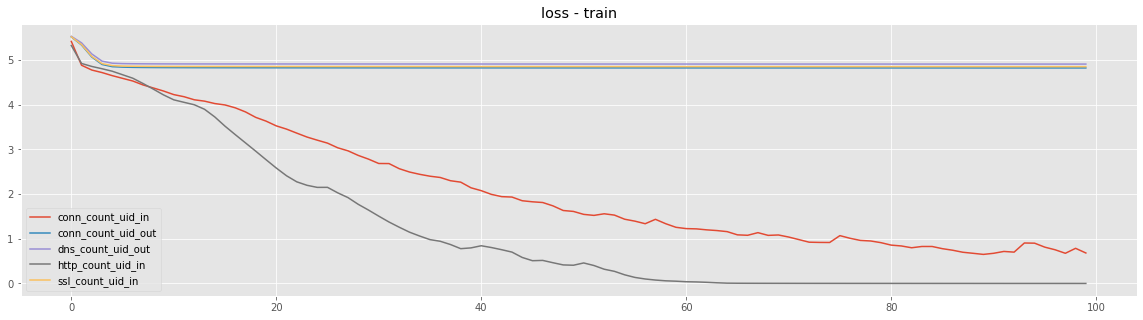

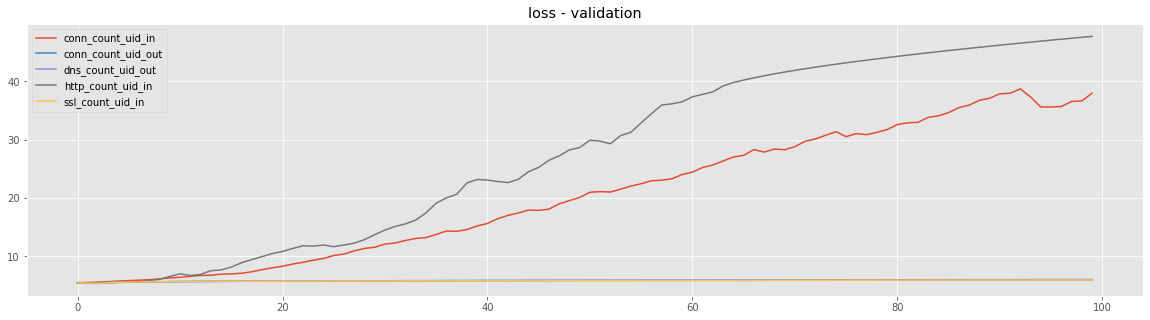

In [26]:
fig = figure=plt.figure(figsize=(20,5))

if len(cfg.train.data.Y) > 1:
    for label in cfg.train.data.Y:
        plt.plot(history.history['%s_loss' % label], figure=fig, label=label)
    plt.title('loss - train')
    plt.legend()
    plt.show()

    fig = figure=plt.figure(figsize=(20,5))
    for label in cfg.train.data.Y:
        plt.plot(history.history['val_%s_loss' % label], figure=fig, label=label)
    plt.title('loss - validation')
    plt.legend()
    plt.show()
else:
    plt.plot(history.history['loss'], figure=fig, label='loss')
    plt.plot(history.history['val_loss'], figure=fig, label='val_loss')
    plt.legend()
    plt.show()

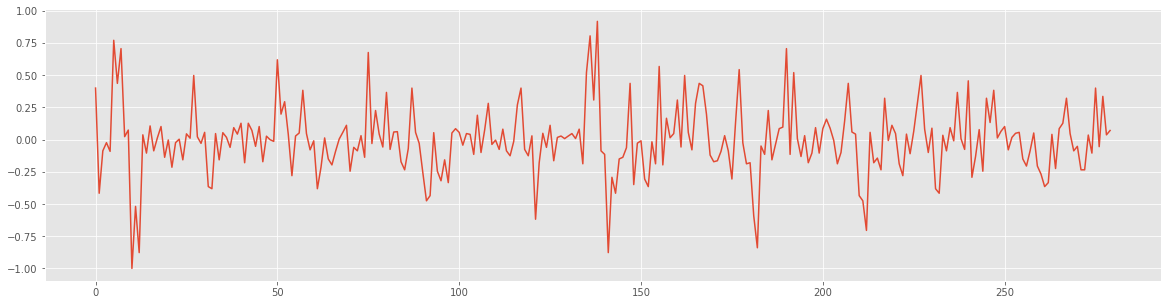

In [27]:
plt.plot(
    mu_law_inv(
        int8_to_float64(
            np.argmax(
                Y_test['ssl_count_uid_in'], axis=1
            )
        )
    ),
    figure=plt.figure(figsize=(20,5))
)
plt.show()

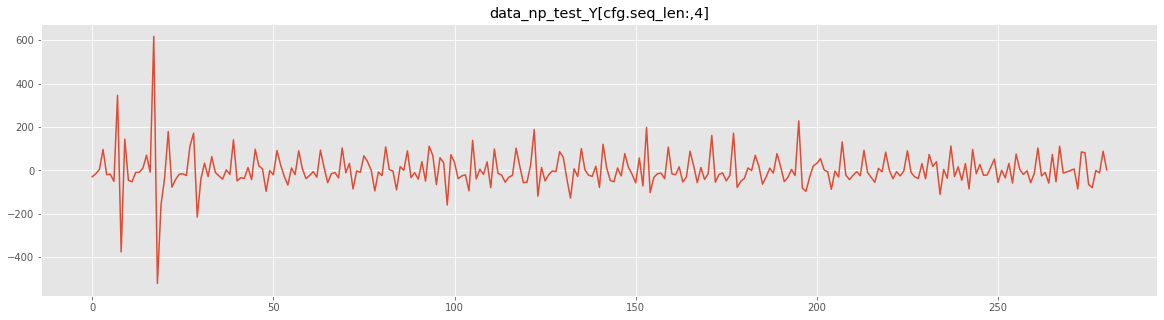

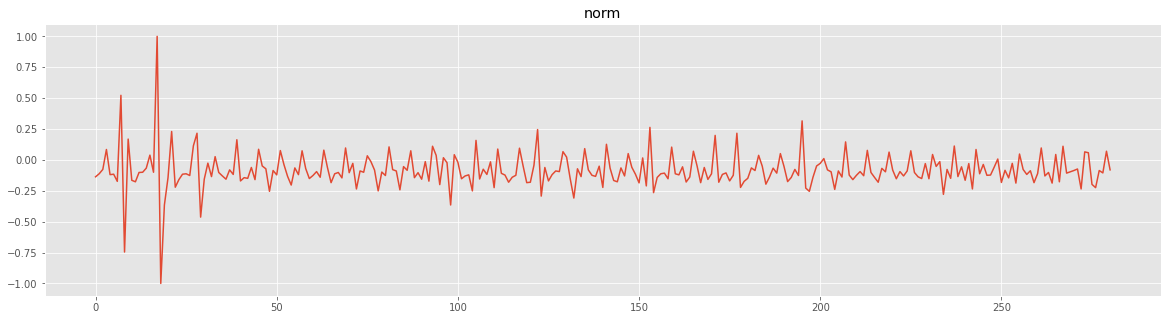

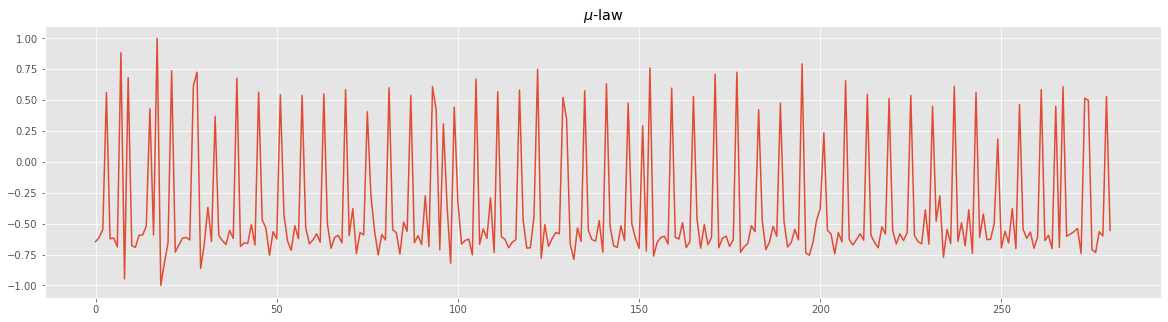

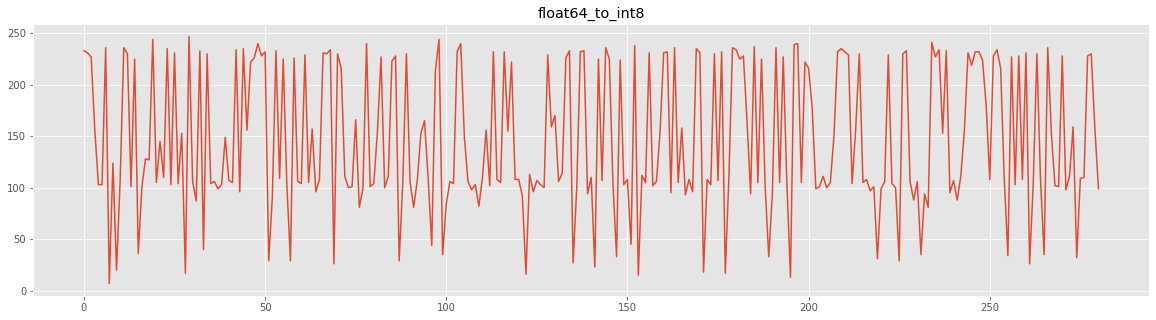

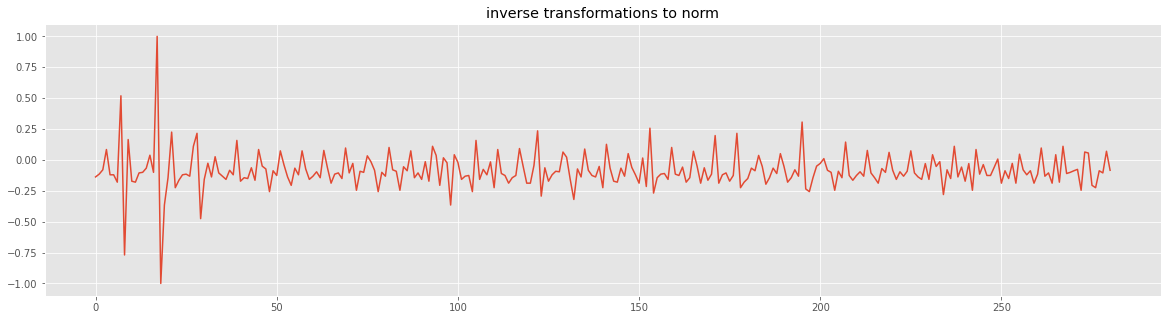

In [28]:
dd = data_np_test_Y[cfg.seq_len:,4]
plt.plot(dd, figure=plt.figure(figsize=(20,5)))
plt.title(r'data_np_test_Y[cfg.seq_len:,4]')
plt.show()

dd = norm(dd)
plt.plot(dd, figure=plt.figure(figsize=(20,5)))
plt.title(r'norm')
plt.show()

dd = mu_law(dd)
plt.plot(dd, figure=plt.figure(figsize=(20,5)))
plt.title(r'$\mu$-law')
plt.show()

dd = float64_to_int8(dd)
plt.plot(float64_to_int8(dd), figure=plt.figure(figsize=(20,5)))
plt.title(r'float64_to_int8')
plt.show()

dd = int8_to_float64(dd)
dd = mu_law_inv(dd)
plt.plot(dd, figure=plt.figure(figsize=(20,5)))
plt.title('inverse transformations to norm')
plt.show()

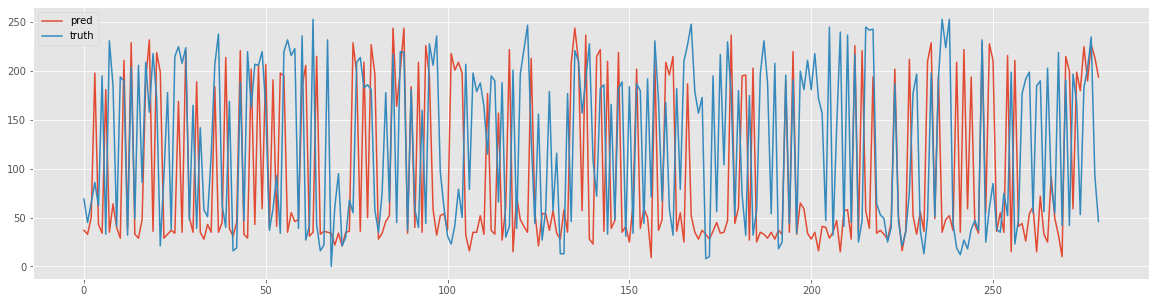

In [32]:
idx=3
pred = model.predict(X_test)
fig = plt.figure(figsize=(20,5))
plt.plot(np.argmax(pred[idx], axis=1), figure=fig, label='pred')
plt.plot(np.argmax(Y_test[cfg.train.data.Y[idx]], axis=1), figure=fig, label='truth')
plt.legend()
plt.show()

### model predicition on train

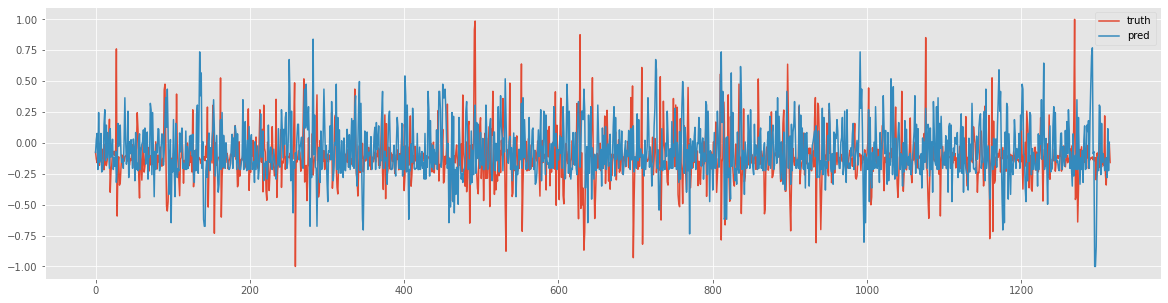

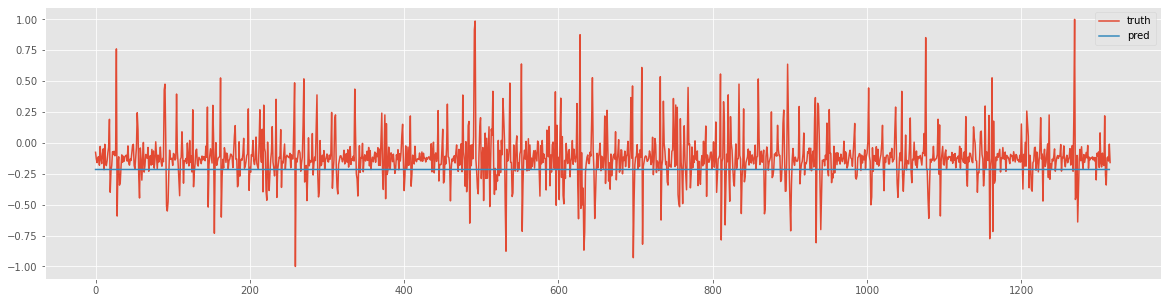

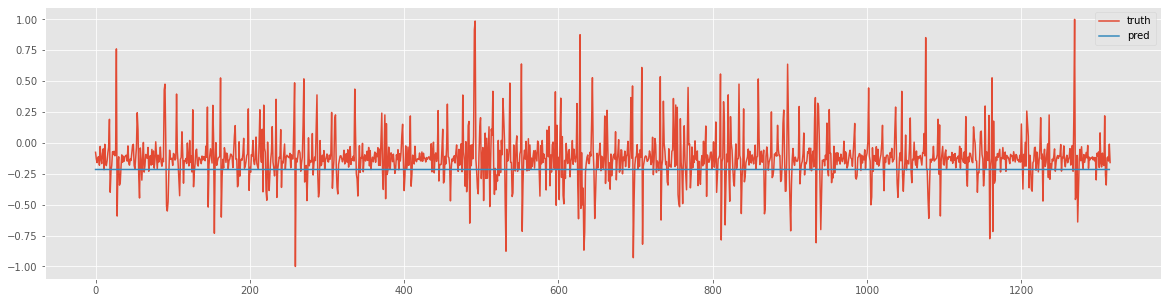

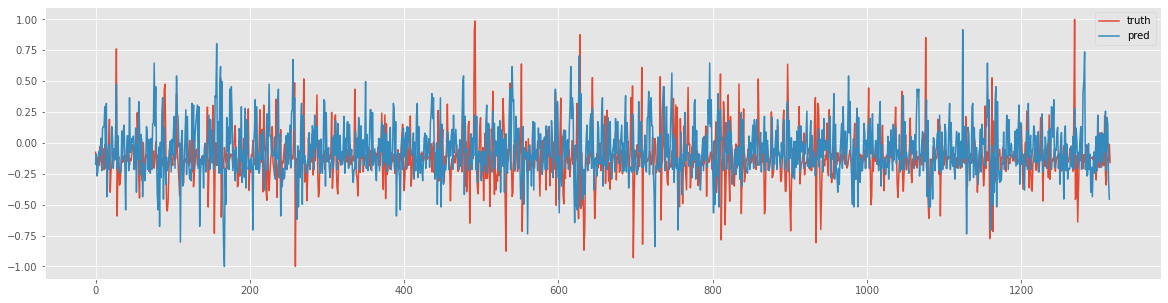

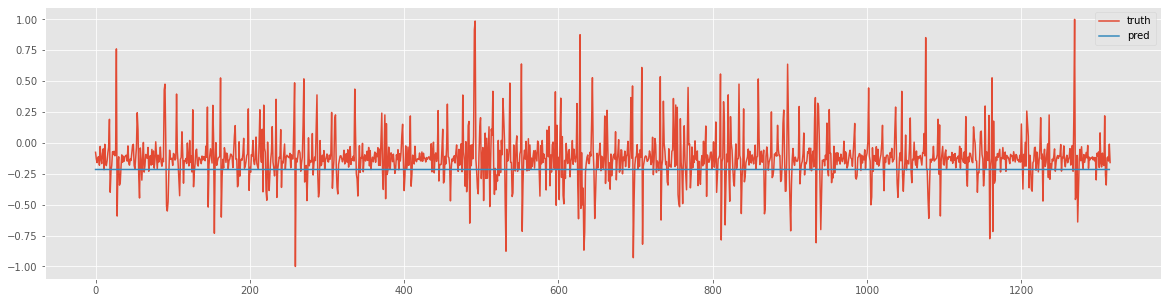

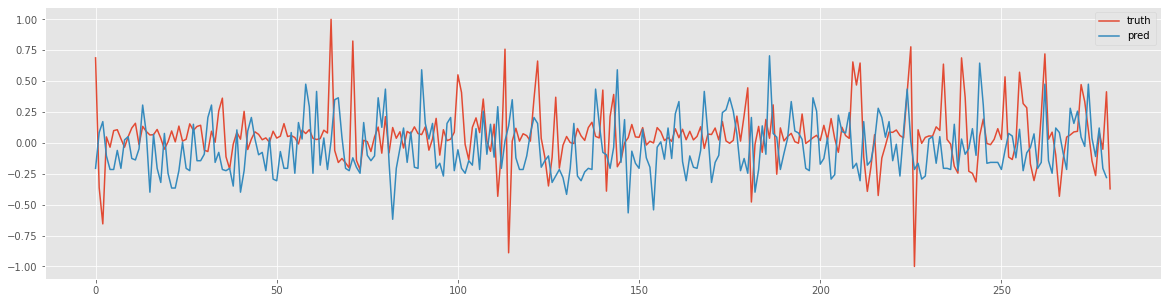

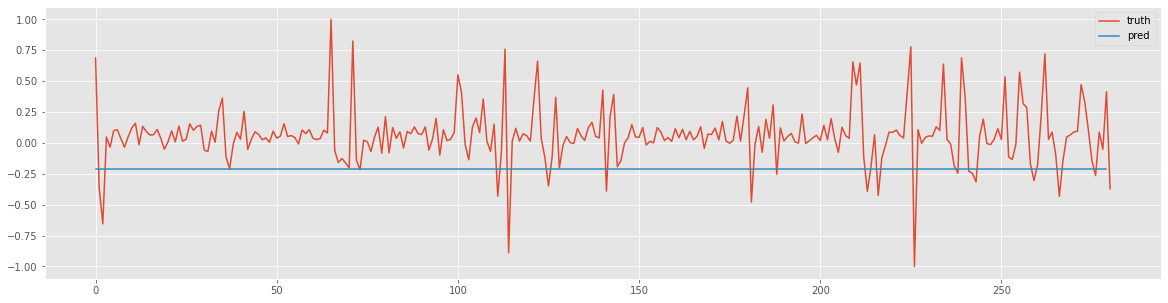

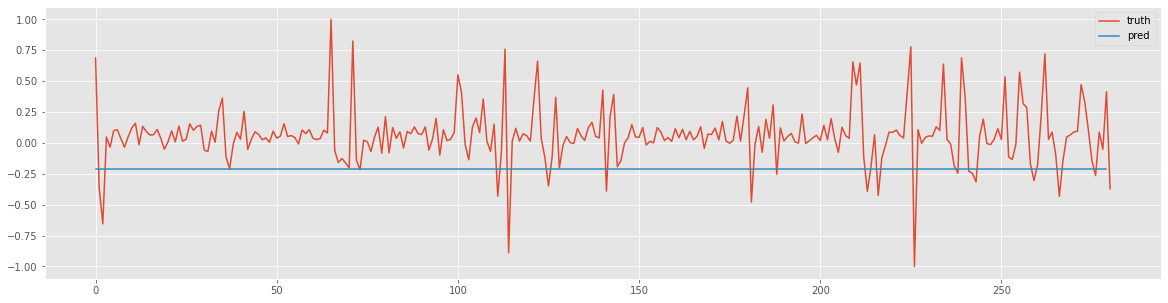

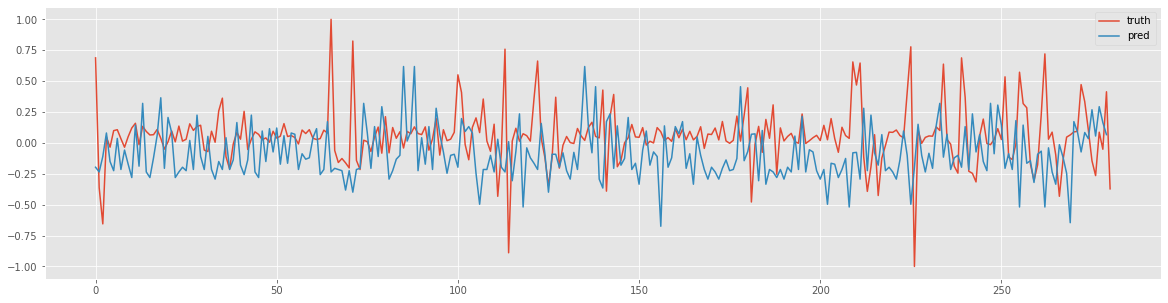

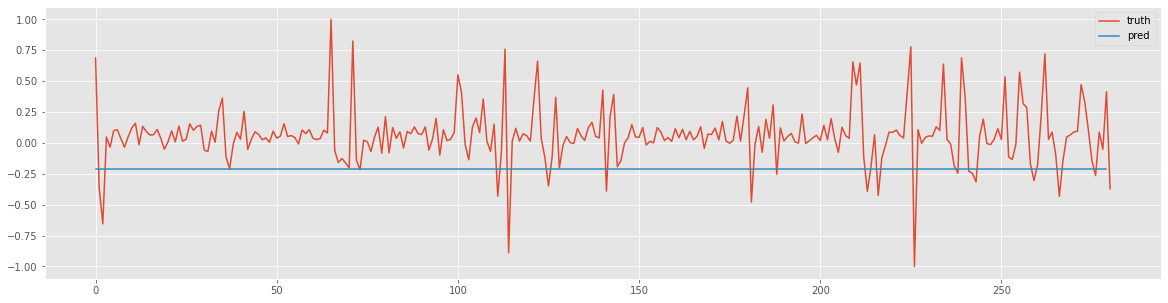

In [33]:
def predict(model, X, Y):

    pred = model.predict(X)

    if isinstance(pred, list):
        for i in range(len(pred)):
            pred[i] = mu_law_inv(int8_to_float64(np.argmax(pred[i], axis=1)))
            fig = plt.figure(figsize=(20,5))
            plt.plot(norm(Y[cfg.seq_len:,0]), figure=fig, label='truth')
            plt.plot(pred[i], figure=fig, label='pred')
            plt.legend()
            plt.show()            
    else:
        pred = mu_law_inv(int8_to_float64(np.argmax(pred, axis=1)))
        fig = plt.figure(figsize=(20,5))
        plt.plot(norm(Y[cfg.seq_len:,0]), figure=fig, label='truth')
        plt.plot(pred, figure=fig, label='pred')
        plt.legend()
        plt.show()

predict(model, X, data_np_train_Y)
predict(model, X_test, data_np_test_Y)